# Measuring the novelty of scientific publications: A fastText and local outlier factor approach

* Authors: Junyoup Lee, Daeseong Jeon, Changyong Lee
* Abstract: Although the novelty of scientific publications has been the subject of previous studies, most have examined the distribution of references in the bibliography, which may not be effective in capturing implied scientific knowledge. We propose an analytical framework for measuring the novelty of scientific publications using a paper’s title. At the heart of the framework, fastText is used to construct a vector space model in which papers with similar scientific knowledge are located close to each other, and the local outlier factor is used to measure the novelty of scientific knowledge implied in the papers on a numerical scale. The feasibility and validity of the analytical framework were assessed by comparing the average novelty scores of papers recommended with novelty-related tags in Faculty Opinions to those of papers without such tags. This case study of 15,653 papers published in a biomedical journal confirms that our framework is a useful complementary tool for the continuous assessment of the novelty of scientific publications and can serve as a starting point for developing more general models.
* Keywords: novelty; scientific publication; paper titles; fastText; local outlier factor

## Module import

In [147]:
# from .modules import common

import os, json, datetime, re, random, itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from scipy.sparse import csr_matrix
from collections import Counter
from itertools import combinations
from numpy import dot
from numpy.linalg import norm
import numpy as np

from gensim.models import fasttext
from gensim.models import FastText
from gensim.models.callbacks import CallbackAny2Vec
from gensim.test.utils import get_tmpfile
from gensim import matutils
from gensim.parsing.preprocessing import *

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from scipy.stats import mannwhitneyu

In [ ]:
from itertools import chain
from tqdm import tqdm
from itertools import combinations
import numpy as np
import itertools
from scipy.sparse import csr_matrix
import json, csv, os, re
import gensim
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter

## Settings and Data loading

### Path settings

In [201]:
DATA_DIR = "data"
PAPERS_DIR = os.path.join(DATA_DIR, "papers")
PAPERS_DETAILS_DIR = os.path.join(PAPERS_DIR, "details")

PAPERS_ALL_PATH = os.path.join(PAPERS_DIR, "cell_all.csv")
PAPERS_RECOM_PATH = os.path.join(PAPERS_DIR, "cell_recom.csv")

### Loading paper information

In [202]:
papers_all = pd.read_csv(PAPERS_ALL_PATH)
papers_all = papers_all[papers_all['type'] == 'Article']
papers_all["PUBMED ID"] = papers_all["PUBMED ID"].fillna(-1).astype(int)

papers_recom = pd.read_csv(PAPERS_RECOM_PATH)
papers_recom = papers_recom.rename(columns={"pubMedId": "PUBMED ID"})

#### All papers published in Cell (from SCOPUS API)

In [203]:
papers_all.head()

,SCOPUS ID,PUBMED ID,title,journal,volume,articlenum,date,type,forward citations,abstract,keywords,authors,backward citations,references fulltexts
2,SCOPUS_ID:0016380203,-1,A uridine kinase-deficient mutant of 3T3 and a...,Cell,1,23-26,1974-01-01,Article,20,A mutant subline deficient in uridine kinase h...,NaN,Medrano L.; Green H.,18.0,NaN
3,SCOPUS_ID:0016379637,-1,"spoT, a new genetic locus involved in the stri...",Cell,1,27-30,1974-01-01,Article,86,"A new genetic locus, spoT, whose product is in...",NaN,Laffler T.; Gallant J.,25.0,NaN
4,SCOPUS_ID:0016379519,-1,Altered metabolism of the guanosine tetraphosp...,Cell,1,85-90,1974-01-01,Article,21,The metabolism of ppGpp is altered in commonly...,NaN,Stamminger G.; Lazzarini R.A.,15.0,NaN
5,SCOPUS_ID:0016378969,-1,The messenger-like poly(A)-containing RNA spec...,Cell,1,31-35,1974-01-01,Article,48,The messenger-like poly(A)-containing RNA asso...,NaN,Hirsch M.; Spradling A.; Penman S.,33.0,NaN
6,SCOPUS_ID:0016378610,-1,Mixed splenocyte cultures and graft versus hos...,Cell,1,55-58,1974-01-01,Article,46,A type C virus different from both the N-tropi...,NaN,Sherr C.J.; Lieber M.M.; Todaro G.J.,30.0,NaN


#### Recommended papers published in Cell (from Faculty Opinions)

In [204]:
papers_recom.head()

,id,PUBMED ID,publishedDateForPrint,title,authors,openAccess
0,742391493,36318920,2022 Oct 25,Multiphase coalescence mediates Hippo pathway ...,Wang L; Choi K; Su T; Li B; Wu X; Zhang R; Dri...,False
1,742386533,36306735,2022 Oct 27,TREM2 drives microglia response to amyloid-β v...,Wang S; Sudan R; Peng V; Zhou Y; Du S; Yuede C...,False
2,742344787,36179670,2022 Sep 29,Pan-cancer analyses reveal cancer-type-specifi...,Narunsky-Haziza L; Sepich-Poore GD; Livyatan I...,False
3,742338825,36167071,2022 Oct 13,Quorum-sensing- and type VI secretion-mediated...,Mashruwala AA; Qin B; Bassler BL,False
4,742306088,36055202,2022 Sep 01,Gut bacterial nutrient preferences quantified ...,Zeng X; Xing X; Gupta M; Keber FC; Lopez JG; L...,False


#### Data sample of posts in Faculty Opinions

In [205]:
with open(os.path.join(PAPERS_DETAILS_DIR, f"742391493.json"), "r") as f: data = json.load(f)
data['pageProps']['initialArticle']['evaluations']

[{'id': 793596405,
  'publishedDate': '2022-11-10',
  'classifications': [{'code': 'NEW_FINDING', 'label': 'New Finding'}],
  'recommendationText': 'The notion that a broad range of key biological processes can be driven and regulated through formation of condensates, generated by liquid-liquid phase separation (LLPS) of biomolecules, is now supported by a large number of published reports. Signal transduction leading to transcriptional regulation has emerged as one important class of condensate-controlled processes. Indeed, LLPS has been linked to the WNT, JAK/ STAT, TGFbeta, and WNK pathways. In general, it is thought that condensate formation by signaling molecules triggers activation of the pathway, while dissolution of a condensate is required to inhibit its activity.<br />\r\n<br />\r\nThe recent paper by Wang et al. now adds the Hippo pathway to the list of critical signal transduction systems that are regulated through condensate dynamics and demonstrates that the capacity of c

#### Concatenate tag information with recommended paper inforamtion

In [206]:
df_tags = []
for id in tqdm(papers_recom.id):
    tags = {
        'id': id,
        'CONTROVERSIAL': 0,
        'GOOD_FOR_TEACHING': 0,
        'CONFIRMATION': 0,
        'TECHNICAL_ADVANCE': 0,
        'NOVEL_DRUG_TARGET': 0,
        'NEW_FINDING': 0,
        'HYPOTHESIS': 0,
        'REFUTATION': 0,
        'NEGATIVE': 0,
    }
    with open(os.path.join(PAPERS_DETAILS_DIR, f"{id}.json"), "r") as f: data = json.load(f)
    for evaluation in data['pageProps']['initialArticle']['evaluations']:
        for tag in evaluation['classifications']:
            tags[tag['code']] += 1
            
    df_tags.append(tags)
    
df_tags = pd.DataFrame(df_tags)
papers_recom = pd.merge(papers_recom, df_tags, how="inner", on="id")
papers_recom

100%|██████████| 4168/4168 [00:29<00:00, 141.86it/s]


,id,PUBMED ID,publishedDateForPrint,title,authors,openAccess,CONTROVERSIAL,GOOD_FOR_TEACHING,CONFIRMATION,TECHNICAL_ADVANCE,NOVEL_DRUG_TARGET,NEW_FINDING,HYPOTHESIS,REFUTATION,NEGATIVE
0,742391493,36318920,2022 Oct 25,Multiphase coalescence mediates Hippo pathway ...,Wang L; Choi K; Su T; Li B; Wu X; Zhang R; Dri...,False,0,0,0,0,0,1,0,0,0
1,742386533,36306735,2022 Oct 27,TREM2 drives microglia response to amyloid-β v...,Wang S; Sudan R; Peng V; Zhou Y; Du S; Yuede C...,False,0,1,0,0,1,1,0,0,0
2,742344787,36179670,2022 Sep 29,Pan-cancer analyses reveal cancer-type-specifi...,Narunsky-Haziza L; Sepich-Poore GD; Livyatan I...,False,0,1,2,0,1,4,2,0,0
3,742338825,36167071,2022 Oct 13,Quorum-sensing- and type VI secretion-mediated...,Mashruwala AA; Qin B; Bassler BL,False,0,1,0,0,0,1,1,0,0
4,742306088,36055202,2022 Sep 01,Gut bacterial nutrient preferences quantified ...,Zeng X; Xing X; Gupta M; Keber FC; Lopez JG; L...,False,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4163,1001284,11348590,2001 May 04,Subunit-specific rules governing AMPA receptor...,Shi S; Hayashi Y; Esteban JA; Malinow R,False,0,0,0,1,0,1,1,0,0
4164,1000171,11257227,2001 Mar 9,Arginine methylation of STAT1 modulates IFNalp...,Mowen KA; Tang J; Zhu W; Schurter BT; Shuai K;...,False,0,0,0,0,0,1,0,0,0
4165,1001197,11511347,2001 Jul 27,Molecular analysis of kinetochore-microtubule ...,He X; Rines DR; Espelin CW; Sorger PK,False,0,0,0,1,0,0,0,0,0
4166,1000053,11057905,2000 Oct 13,Novel signaling from the peripodial membrane i...,Cho KO; Chern J; Izaddoost S; Choi KW,False,0,0,0,0,0,1,0,0,0


<AxesSubplot:>

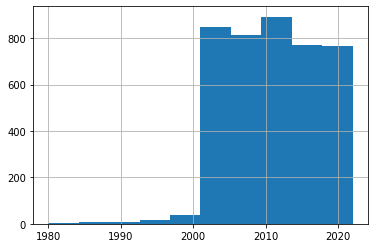

In [207]:
papers_recom['publishedDateForPrint'].apply(lambda x: x[:4]).sort_values()[2:].astype(int).hist()

#### Merge paper information from SCOPUS and Faculty Opinions

In [208]:
papers_all_tags = pd.merge(papers_all, papers_recom.drop(columns=["title", "authors", "openAccess", "publishedDateForPrint"]), how="left", on="PUBMED ID")
papers_all_tags[papers_all_tags.columns[-9:]] = papers_all_tags[papers_all_tags.columns[-9:]].fillna(0)
papers_all_tags["date"] = pd.to_datetime(papers_all_tags["date"])
papers_all_tags["year"] = papers_all_tags["date"].dt.year
papers_all_tags = papers_all_tags[papers_all_tags.year < 2022]
papers_all_tags

,SCOPUS ID,PUBMED ID,title,journal,volume,articlenum,date,type,forward citations,abstract,...,CONTROVERSIAL,GOOD_FOR_TEACHING,CONFIRMATION,TECHNICAL_ADVANCE,NOVEL_DRUG_TARGET,NEW_FINDING,HYPOTHESIS,REFUTATION,NEGATIVE,year
0,SCOPUS_ID:0016380203,-1,A uridine kinase-deficient mutant of 3T3 and a...,Cell,1,23-26,1974-01-01,Article,20,A mutant subline deficient in uridine kinase h...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974
1,SCOPUS_ID:0016379637,-1,"spoT, a new genetic locus involved in the stri...",Cell,1,27-30,1974-01-01,Article,86,"A new genetic locus, spoT, whose product is in...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974
2,SCOPUS_ID:0016379519,-1,Altered metabolism of the guanosine tetraphosp...,Cell,1,85-90,1974-01-01,Article,21,The metabolism of ppGpp is altered in commonly...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974
3,SCOPUS_ID:0016378969,-1,The messenger-like poly(A)-containing RNA spec...,Cell,1,31-35,1974-01-01,Article,48,The messenger-like poly(A)-containing RNA asso...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974
4,SCOPUS_ID:0016378610,-1,Mixed splenocyte cultures and graft versus hos...,Cell,1,55-58,1974-01-01,Article,46,A type C virus different from both the N-tropi...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15648,SCOPUS_ID:85096517151,33232691,Cryo-EM Structure of an Extended SARS-CoV-2 Re...,Cell,184,184-193.e10,2021-01-07,Article,97,© 2020 Elsevier Inc.Yan et al. present a cryo-...,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2021
15649,SCOPUS_ID:85096507789,33278357,Synergism of TNF-α and IFN-γ Triggers Inflamma...,Cell,184,149-168.e17,2021-01-07,Article,407,© 2020 Elsevier Inc.TNF-α and IFN-γ synergize ...,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2021
15650,SCOPUS_ID:85095819080,33147445,Identification of Required Host Factors for SA...,Cell,184,92-105.e16,2021-01-07,Article,231,© 2020 Elsevier Inc.To better understand host-...,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2021
15651,SCOPUS_ID:85094142079,33147444,Genome-wide CRISPR Screens Reveal Host Factors...,Cell,184,76-91.e13,2021-01-07,Article,201,© 2020 Elsevier Inc.To identify potential ther...,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2021


## Main process

### Pre-processing

In [209]:
def get_keywords(df, year, until=False, column="title"):
    '''
        Get words from paper information after preprocessing
        
        - df: Paper information
        - year: Year of interest
        - until:
            * True: Published papers until the year entered.
            * False: Published papers in the year entered. 
        - column: Column of paper section to be used for paper vectorisation
    '''
    if until: df_year = df[df["year"] <= year]
    else: df_year = df[df["year"] == year]
    
    scopus_ids = list(df_year.index)
    if column == "keywords": keywords = [k.lower().split("; ") for k in df_year[column].values]
    else: keywords = [preprocess_string(k, filters=[strip_tags, strip_punctuation,strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short]) for k in df_year[column].values]
        
    return scopus_ids, keywords

### Development of a paper (and word) landscape using fastText

In [252]:
class EpochLogger(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        self.epoch += 1
        # if self.epoch % 20 == 0:
        #     print('Epoch {}'.format(self.epoch))
            
def further_training_by_year(df, year, pretrained_model_path="models/pretrained/wiki.en.bin", model_dir="model", column="title", epochs=200):
    '''
        Further train the pre-trained fastText model using papers collected.
        
        - df: Paper information
        - year: Year of a paper landscape
        - pretrained_model_path: path of the pre-trained fastText model
        - model_dir: directory path to save the model trained
        - column: Column of paper section to be used for paper vectorisation
        - epoch: the number of epoch
    '''
    print("Load pretrained model")
    model = fasttext.load_facebook_model(pretrained_model_path)
    model.min_count = 0
    model.window = 2 ** 30

    model_dir = os.path.join(model_dir, f"year={year}")
    
    scopus_ids, keywords = get_keywords(df, year, until=True, column=column)
    epoch_logger = EpochLogger()
    
    print("Build vocab")
    model.build_vocab(keywords, update=True)
   
    model.train(
        corpus_iterable=keywords,
        total_examples=len(keywords),
        epochs=epochs,
        callbacks=[epoch_logger],
    )
    
    print("Model saving ")
    model.save(f'{model_dir}/epoch{epochs}.model')

    print("MAKE Document embeddings")
    docvecs = np.array([keywords2vec(model, keyword) for keyword in keywords])
    np.save(f"data/docvecs/fastText/docvecs{epochs}_year={year}.npy", docvecs)
    return model

In [ ]:
PRETRAINED_MODELS_DIR = "model/pretrained"
FURTHER_TRAINED_MODELS_DIR = "model/further-trained"

os.mkdirs(PRETRAINED_MODELS_DIR)
os.mkdirs(FURTHER_TRAINED_MODELS_DIR)

#### Download pretrained fastText model

In [265]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.zip -P "model/pretrained"

--2023-07-03 22:58:48--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.86.207.41, 99.86.207.76, 99.86.207.39, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.86.207.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10356881291 (9.6G) [application/zip]
Saving to: ‘model/pretrained/wiki.en.zip’

wiki.en.zip         100%[===================>]   9.65G  34.1MB/s    in 7m 2s   

2023-07-03 23:05:55 (23.4 MB/s) - ‘model/pretrained/wiki.en.zip’ saved [10356881291/10356881291]



In [280]:
!unzip "model/pretrained/wiki.en.zip" -d "model/pretrained"

Archive:  model/pretrained/wiki.en.zip
  inflating: model/pretrained/wiki.en.vec  
  inflating: model/pretrained/wiki.en.bin  


In [281]:
!rm "model/pretrained/wiki.en.vec"
!rm "model/pretrained/wiki.en.zip"

#### Further training

In [102]:
for year in range(min(papers_all_tags["year"]), max(papers_all_tags["year"]+1)):
    print(f"YEAR: {year}")
    further_training_by_year(papers_all_tags, year, model_dir=FURTHER_TRAINED_MODELS_DIR, column='title', epochs=200)

YEAR: 1974
Load pretrained model
Build vocab
Epoch 20
Epoch 40
Epoch 60
Epoch 80
Epoch 100
Epoch 120
Epoch 140
Epoch 160
Epoch 180
Epoch 200
Model saving 
MAKE Document embeddings
YEAR: 1975
Load pretrained model
Build vocab
Epoch 20
Epoch 40
Epoch 60
Epoch 80
Epoch 100
Epoch 120
Epoch 140
Epoch 160
Epoch 180
Epoch 200
Model saving 
MAKE Document embeddings
YEAR: 1976
Load pretrained model


KeyboardInterrupt: 

### Measurement of the novelty of the papers using the LOF

In [ ]:
def measuring_novelties(docvecs, neighbors=10, method="LOF"):
    '''
        Based on document vectors, measure the novelty score using outlier detection methods
        
        - docvecs: Document vectors
        - neighbors: LOF hyperparameter
    '''
    
    assert method in ["LOF", "IF"]

    if method == "LOF":
        clf = LocalOutlierFactor(n_neighbors=neighbors)
        clf.fit(docvecs)
        novelty = clf.negative_outlier_factor_ * -1
    elif method == "IF":
        clf = IsolationForest()
        clf.fit(docvecs)
        novelty = clf.score_samples(docvecs) * -1
        
    return novelty

In [251]:
for year in range(min(papers_all_tags["year"]), max(papers_all_tags["year"]) + 1):
    docvecs = np.load(f"data/docvecs/fastText/docvecs200_year={year}.npy")
    scopus_ids, keywords = get_keywords(papers_all_tags, year, until=True, column="title")
    novelties_LOF = measuring_novelties(docvecs, method="LOF")
    novelties_IF = measuring_novelties(docvecs, method="IF")
    
    scopus_ids_year = papers_all_tags[papers_all_tags["year"] == year].index.to_list()
    pbar = tqdm(scopus_ids_year)
    
    for scopus_id in pbar:
        pbar.set_description(f"Year: {year}")
        papers_all_tags.loc[scopus_id, f"fastText+LOF"] = novelties_LOF[scopus_ids.index(scopus_id)]
        papers_all_tags.loc[scopus_id, f"fastText+IF"] = novelties_IF[scopus_ids.index(scopus_id)]

Year: 2021: 100%|██████████| 448/448 [00:01<00:00, 387.74it/s]


### Validation
> A comparison of average novelty scores measured by the proposed approach between papers with and without novelty-related tags in the Faculty Opinions database using the Mann-Whitney U test.

In [118]:
def compare_novel_non_novel_papers(df, novelty_column, tag_columns):
    set_a = []
    set_b = []
    results = []
    for col in tag_columns:
        novel = df[df[col] > 0]
        non_novel = df[df[col] == 0]

        U1, p = mannwhitneyu(novel[novelty_column], non_novel[novelty_column])
        
        novel_avg = round(novel[novelty_column].mean(), 4)
        non_novel_avg = round(non_novel[novelty_column].mean(), 4)
        
        result = {
            "novelty_name": novelty_column,
            "tag": col,
            "U1": U1,
            "p": p,
            "novel_avg": novel_avg,
            "non_novel_avg": non_novel_avg,
        }
        
        results.append(result)
        
        set_a.append(novel_avg)
        set_b.append(non_novel_avg)
    return pd.DataFrame(results)

#### Table 3

In [254]:
model_name = "fastText+LOF"
columns = ["TECHNICAL_ADVANCE", "NOVEL_DRUG_TARGET", "NEW_FINDING", "HYPOTHESIS"]
results = compare_novel_non_novel_papers(papers_all_tags, model_name, columns)
results

,novelty_name,tag,U1,p,novel_avg,non_novel_avg
0,fastText+LOF,TECHNICAL_ADVANCE,5104926.0,1.006577e-19,1.1037,1.0811
1,fastText+LOF,NOVEL_DRUG_TARGET,3066729.0,4.537138e-07,1.0956,1.0819
2,fastText+LOF,NEW_FINDING,18848451.0,4.374682e-44,1.0956,1.0782
3,fastText+LOF,HYPOTHESIS,9380543.0,2.070568e-17,1.0952,1.0809


## Discussion

### Quality of further trained model
> We compared the average pairwise similarity between words for each paper’s title both before and after further training.

In [125]:
def keywords2avg_distance(model, keywords):
    '''
        Return average pairwise cosine similarity between words using the model entered.
        
        Input
        - model: word embedding model
        - keywords: words to be used
        
        Output
        - result: average pairwise cosine similarity
    '''
    def cos_sim(v1, v2): return dot(v1, v2)/(norm(v1)*norm(v2))

    avg_sims = []
    for doc in tqdm(keywords):
        if len(doc) < 2: continue
        vectors = []
        for k in doc: vectors.append(model.wv[k])

        total = []
        for i, v1 in enumerate(vectors):
            for j, v2 in enumerate(vectors):
                if i >= j: continue
                sim = cos_sim(v1, v2)
                total.append(sim)

        avg_sim = sum(total) / len(total)
        avg_sims.append(avg_sim)
        
    result = sum(avg_sims) / len(avg_sims)
    return result

In [213]:
_, keywords = get_keywords(papers_all_tags, year=2021, until=True, column="title")

#### Average similarity of the pretrained model

In [282]:
pretrained_model = fasttext.load_facebook_model('model/pretrained/wiki.en.bin')

In [283]:
keywords2avg_distance(pretrained_model, keywords)

100%|██████████| 15653/15653 [00:10<00:00, 1448.12it/s]


0.25764622875599386

In [ ]:
further_trained_model = FastText.load(f"model/further-trained/year={year}/epoch200.model")

In [284]:
keywords2avg_distance(further_trained_model, keywords)

100%|██████████| 15653/15653 [00:07<00:00, 2001.36it/s]


0.45694113319235724

### External validity of previous combinatorial novelty scores

In [131]:
with open(os.path.join(PAPERS_DIR, 'reference_data.json'), 'r') as f:
    ref_data = json.load(f)
len(ref_data)

15866

#### Originality
> Trajtenberg, M., Henderson, R., Jaffe, A., 1997. University versus corporate patents: A window on the basicness of invention. Economics of Innovation and new technology, 5 (1), 19–50.

In [132]:
def measure_originality(paper):
    bag_of_asjc = {}
    
    journal_asjc = paper["journal_asjc"]
    others_asjc = paper["others_asjc"]
    
    for source_title, asjc_codes, _ in journal_asjc + others_asjc:
        if asjc_codes:
            weight = 1 / len(asjc_codes)
            for asjc in asjc_codes:
                if asjc in bag_of_asjc: bag_of_asjc[asjc] += weight
                else: bag_of_asjc[asjc] = weight
    
    originality = 1 - sum([(val / sum(bag_of_asjc.values())) ** 2 for val in bag_of_asjc.values()])
    return originality

In [219]:
originalities = {}
for scopus_id in tqdm(ref_data):
    originality = measure_originality(ref_data[scopus_id])
    originalities[scopus_id] = originality

100%|██████████| 15866/15866 [00:00<00:00, 27435.80it/s]


In [220]:
papers_all_tags["originality"] = papers_all_tags["SCOPUS ID"].map(originalities)

In [221]:
papers_all_tags

,SCOPUS ID,PUBMED ID,title,journal,volume,articlenum,date,type,forward citations,abstract,...,GOOD_FOR_TEACHING,CONFIRMATION,TECHNICAL_ADVANCE,NOVEL_DRUG_TARGET,NEW_FINDING,HYPOTHESIS,REFUTATION,NEGATIVE,year,originality
0,SCOPUS_ID:0016380203,-1,A uridine kinase-deficient mutant of 3T3 and a...,Cell,1,23-26,1974-01-01,Article,20,A mutant subline deficient in uridine kinase h...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974,0.844785
1,SCOPUS_ID:0016379637,-1,"spoT, a new genetic locus involved in the stri...",Cell,1,27-30,1974-01-01,Article,86,"A new genetic locus, spoT, whose product is in...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974,0.820816
2,SCOPUS_ID:0016379519,-1,Altered metabolism of the guanosine tetraphosp...,Cell,1,85-90,1974-01-01,Article,21,The metabolism of ppGpp is altered in commonly...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974,0.771991
3,SCOPUS_ID:0016378969,-1,The messenger-like poly(A)-containing RNA spec...,Cell,1,31-35,1974-01-01,Article,48,The messenger-like poly(A)-containing RNA asso...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974,0.768800
4,SCOPUS_ID:0016378610,-1,Mixed splenocyte cultures and graft versus hos...,Cell,1,55-58,1974-01-01,Article,46,A type C virus different from both the N-tropi...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974,0.769387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15648,SCOPUS_ID:85096517151,33232691,Cryo-EM Structure of an Extended SARS-CoV-2 Re...,Cell,184,184-193.e10,2021-01-07,Article,97,© 2020 Elsevier Inc.Yan et al. present a cryo-...,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2021,0.908626
15649,SCOPUS_ID:85096507789,33278357,Synergism of TNF-α and IFN-γ Triggers Inflamma...,Cell,184,149-168.e17,2021-01-07,Article,407,© 2020 Elsevier Inc.TNF-α and IFN-γ synergize ...,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2021,0.912680
15650,SCOPUS_ID:85095819080,33147445,Identification of Required Host Factors for SA...,Cell,184,92-105.e16,2021-01-07,Article,231,© 2020 Elsevier Inc.To better understand host-...,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2021,0.896193
15651,SCOPUS_ID:85094142079,33147444,Genome-wide CRISPR Screens Reveal Host Factors...,Cell,184,76-91.e13,2021-01-07,Article,201,© 2020 Elsevier Inc.To identify potential ther...,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2021,0.920489


#### Wang's novelty indicator
> Wang, J., Veugelers, R., Stephan, P., 2017. Bias against novelty in science: A cautionary tale for users of bibliometric indicators. Research Policy, 46 (8), 1416–1436.

In [225]:
class WangNovelty:
    def __init__(self, meta_data, ref_data, start_year=2011):
        self.meta_data = meta_data
        self.ref_data = ref_data
        self.start_year = start_year
        self.cumulated_pair = self.get_initial_pairs()
        self.vocab = self.get_vocab()
    
    def get_sources(self, scopus_id):
        ref_list = self.ref_data[scopus_id]['journal_asjc'] + self.ref_data[scopus_id]['others_asjc']
        sources = [ref[0] for ref in ref_list if ref[2] == 'journal source title']
        return sources
    
    def get_vocab(self):
        print("Start initialize journal vocabulary.....")
#         scopus_ids = self.meta_data.index.to_list()
        scopus_ids = self.meta_data["SCOPUS ID"].to_list()
        
        distinct_sources = set()
        for scopus_id in tqdm(scopus_ids):
            sources = self.get_sources(scopus_id)
            distinct_sources.update(sources)
        
        print(f"Length of vocab: {len(distinct_sources)}")
        return distinct_sources
    
    def get_initial_pairs(self, journal_only=True):
        print("Start initialize cumulated journal pairs.....")
        ref_data = self.ref_data
        # scopus_ids = self.meta_data[self.meta_data['year'] < self.start_year].index.to_list()
        scopus_ids = self.meta_data[self.meta_data['year'] < self.start_year]["SCOPUS ID"].to_list()
        pairs = set()
        for scopus_id in tqdm(scopus_ids):
            sources = self.get_sources(scopus_id)
            sources_vocab = set(sources)
            pairs.update(set(combinations(sources_vocab, 2))) 
        
        print("Done.")
        return pairs
    
    def get_cocitation_matrix(self, year, window=3):
        # scopus_ids = self.meta_data[(year-window <= self.meta_data['year']) & (self.meta_data['year'] < year)].index.to_list()
        scopus_ids = self.meta_data[(year-window <= self.meta_data['year']) & (self.meta_data['year'] < year)]["SCOPUS ID"].to_list()
        documents = [] # 각 논문에 속하는 저널의 **종류**
        cited_journals = []
        for scopus_id in scopus_ids:
            sources = self.get_sources(scopus_id)
            documents.append(set(sources))
            cited_journals += sources
        
        # 제한 사항 구현
        journal_counter = Counter(cited_journals)
        valid_journals = [key for key, val in journal_counter.most_common(int(len(journal_counter) / 2))]
        
        cocitation_matrix, journal_to_id = self.coocurrence_matrix(self.vocab, documents)
        return cocitation_matrix, journal_to_id, valid_journals
            
    def coocurrence_matrix(self, allowed_words, documents):
#         print(f"allowed_words:\n{allowed_words}")
#         print(f"documents:\n{documents}")
        word_to_id = dict(zip(allowed_words, range(len(allowed_words))))
        documents_as_ids = [np.sort([word_to_id[w] for w in doc if w in word_to_id]).astype('uint32') for doc in documents]
        row_ind, col_ind = zip(*itertools.chain(*[[(i, w) for w in doc] for i, doc in enumerate(documents_as_ids)]))
        data = np.ones(len(row_ind), dtype='uint32')  # use unsigned int for better memory utilization
        # max_word_id = max(itertools.chain(*documents_as_ids)) + 1
        max_word_id = len(word_to_id)
        docs_words_matrix = csr_matrix((data, (row_ind, col_ind)), shape=(len(documents_as_ids), max_word_id))  # efficient arithmetic operations with CSR * CSR
        words_cooc_matrix = docs_words_matrix.T * docs_words_matrix  # multiplying docs_words_matrix with its transpose matrix would generate the co-occurences matrix
        words_cooc_matrix.setdiag(0)
#         print(f"words_cooc_matrix:\n{words_cooc_matrix.todense()}")
        return words_cooc_matrix.todense(), word_to_id 
    
    def cosine_similarity(self, v1, v2):
        v1 = np.array(v1)[0]
        v2 = np.array(v2)[0]
        
        norm1 = np.linalg.norm(v1)
        norm2 = np.linalg.norm(v2)
        
        if norm1 == 0 or norm2 == 0: return 0
        else: return np.dot(v1, v2)/(norm1 * norm2)
        
    
    def calculate_novelty(self, verbose=False):
        ref_data = self.ref_data
        novelties = {}
        for year in range(self.start_year, 2022+1):
            print(f"year={year}")
#             scopus_ids = self.meta_data[self.meta_data['year'] == year].index.to_list()
            scopus_ids = self.meta_data[self.meta_data['year'] == year]["SCOPUS ID"].to_list()
            cocitation_matrix, journal_to_id, valid_journals = self.get_cocitation_matrix(year)
            
            pairs_update = set()
            for scopus_id in scopus_ids:
                novelty = 0
                
                sources = self.get_sources(scopus_id)
                sources_pairs = set(combinations(sources, 2))
                pairs_update.update(sources_pairs)
                
                new_pairs = sources_pairs - self.cumulated_pair
                
                excepted_pairs = 0
                for J1, J2 in new_pairs:
                    if not (J1 in valid_journals and J2 in valid_journals):
                        excepted_pairs += 1
                        continue
                    J1_idx = journal_to_id[J1]
                    J2_idx = journal_to_id[J2]
                    
                    J1_vec = cocitation_matrix[J1_idx, :]
                    J2_vec = cocitation_matrix[J2_idx, :]
                    
                    novelty += (1 - self.cosine_similarity(J1_vec, J2_vec))
                
                if verbose: print(f'{scopus_id}: Among {len(sources_pairs)} combinations, {len(new_pairs)} of new combinations exist. And, {excepted_pairs} of combinations were removed.')
                novelties[scopus_id] = novelty
                
            self.cumulated_pair.update(pairs_update)
        
        return novelties

In [238]:
WN = WangNovelty(meta_data=papers_all_tags, ref_data=ref_data, start_year=2011)

 28%|██▊       | 3239/11527 [00:00<00:00, 32382.93it/s]

Start initialize cumulated journal pairs.....


100%|██████████| 15653/15653 [00:00<00:00, 81744.73it/s]


Done.
Start initialize journal vocabulary.....
Length of vocab: 3359


In [239]:
wangs_novelties = WN.calculate_novelty()

year=2011


/home2/nero96in/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


year=2012


/home2/nero96in/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


year=2013


/home2/nero96in/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


year=2014


/home2/nero96in/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


year=2015


/home2/nero96in/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


year=2016


/home2/nero96in/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


year=2017


/home2/nero96in/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


year=2018


/home2/nero96in/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


year=2019


/home2/nero96in/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


year=2020


/home2/nero96in/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


year=2021


/home2/nero96in/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


year=2022


/home2/nero96in/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [240]:
papers_all_tags["Wang's novelty"] = papers_all_tags["SCOPUS ID"].map(wangs_novelties)

In [241]:
papers_all_tags

,SCOPUS ID,PUBMED ID,title,journal,volume,articlenum,date,type,forward citations,abstract,...,CONFIRMATION,TECHNICAL_ADVANCE,NOVEL_DRUG_TARGET,NEW_FINDING,HYPOTHESIS,REFUTATION,NEGATIVE,year,originality,Wang's novelty
0,SCOPUS_ID:0016380203,-1,A uridine kinase-deficient mutant of 3T3 and a...,Cell,1,23-26,1974-01-01,Article,20,A mutant subline deficient in uridine kinase h...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974,0.844785,NaN
1,SCOPUS_ID:0016379637,-1,"spoT, a new genetic locus involved in the stri...",Cell,1,27-30,1974-01-01,Article,86,"A new genetic locus, spoT, whose product is in...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974,0.820816,NaN
2,SCOPUS_ID:0016379519,-1,Altered metabolism of the guanosine tetraphosp...,Cell,1,85-90,1974-01-01,Article,21,The metabolism of ppGpp is altered in commonly...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974,0.771991,NaN
3,SCOPUS_ID:0016378969,-1,The messenger-like poly(A)-containing RNA spec...,Cell,1,31-35,1974-01-01,Article,48,The messenger-like poly(A)-containing RNA asso...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974,0.768800,NaN
4,SCOPUS_ID:0016378610,-1,Mixed splenocyte cultures and graft versus hos...,Cell,1,55-58,1974-01-01,Article,46,A type C virus different from both the N-tropi...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1974,0.769387,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15648,SCOPUS_ID:85096517151,33232691,Cryo-EM Structure of an Extended SARS-CoV-2 Re...,Cell,184,184-193.e10,2021-01-07,Article,97,© 2020 Elsevier Inc.Yan et al. present a cryo-...,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2021,0.908626,9.484737
15649,SCOPUS_ID:85096507789,33278357,Synergism of TNF-α and IFN-γ Triggers Inflamma...,Cell,184,149-168.e17,2021-01-07,Article,407,© 2020 Elsevier Inc.TNF-α and IFN-γ synergize ...,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2021,0.912680,46.690230
15650,SCOPUS_ID:85095819080,33147445,Identification of Required Host Factors for SA...,Cell,184,92-105.e16,2021-01-07,Article,231,© 2020 Elsevier Inc.To better understand host-...,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2021,0.896193,8.542442
15651,SCOPUS_ID:85094142079,33147444,Genome-wide CRISPR Screens Reveal Host Factors...,Cell,184,76-91.e13,2021-01-07,Article,201,© 2020 Elsevier Inc.To identify potential ther...,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2021,0.920489,17.319004


#### Table 4

In [242]:
model_name = "originality"
columns = ["TECHNICAL_ADVANCE", "NOVEL_DRUG_TARGET", "NEW_FINDING", "HYPOTHESIS"]
results = compare_novel_non_novel_papers(papers_all_tags, model_name, columns)
results

,novelty_name,tag,U1,p,novel_avg,non_novel_avg
0,originality,TECHNICAL_ADVANCE,4301460.0,3.743249e-53,0.8492,0.8137
1,originality,NOVEL_DRUG_TARGET,1416094.5,1.980683e-108,0.8769,0.8138
2,originality,NEW_FINDING,13492230.5,2.750833e-286,0.8483,0.8055
3,originality,HYPOTHESIS,7219841.0,7.668891e-101,0.8483,0.8121


In [243]:
model_name = "Wang's novelty"
columns = ["TECHNICAL_ADVANCE", "NOVEL_DRUG_TARGET", "NEW_FINDING", "HYPOTHESIS"]
results = compare_novel_non_novel_papers(papers_all_tags, model_name, columns)
results

,novelty_name,tag,U1,p,novel_avg,non_novel_avg
0,Wang's novelty,TECHNICAL_ADVANCE,3983423.0,4.171470e-71,7.8731,8.6163
1,Wang's novelty,NOVEL_DRUG_TARGET,2108288.5,2.038916e-50,13.0595,8.1089
2,Wang's novelty,NEW_FINDING,17382144.0,4.886867e-89,9.0485,8.0522
3,Wang's novelty,HYPOTHESIS,8376219.5,2.810182e-47,9.6232,8.2590


### Use of other embedding and anomaly detection methods

In [261]:
papers_all_tags.to_csv("data/papers_all_tags.csv")

#### Get document vectors from ELMo and BERT
> Before running the codes below, run `make_elmobert_docvecs.py` to make `docvecs` for ELMo and BERT

In [247]:
bert_docvecs = np.load("data/docvecs/bert_avg_docvecs_cell_title.npy")
elmo_docvecs = np.load("data/docvecs/elmo_title_cell_docvecs.npy")

In [262]:
for year in range(min(papers_all_tags["year"]), max(papers_all_tags["year"]) + 1):
    # docvecs = np.load(f"model/cell/further_trained_year={year}/docvecs200.npy")
    scopus_ids, keywords = get_keywords(papers_all_tags, year, until=True, column="title")
    scopus_ids_year = papers_all_tags[papers_all_tags["year"] == year].index.to_list()
    
    bert_docvecs_year = bert_docvecs[:len(scopus_ids)]
    elmo_docvecs_year = elmo_docvecs[:len(scopus_ids)]
    
    bert_novelties_LOF = measuring_novelties(bert_docvecs_year, method="LOF")
    bert_novelties_IF = measuring_novelties(bert_docvecs_year, method="IF")
    
    elmo_novelties_LOF = measuring_novelties(elmo_docvecs_year, method="LOF")
    elmo_novelties_IF = measuring_novelties(elmo_docvecs_year, method="IF")
    
    pbar = tqdm(scopus_ids_year)
    
    for scopus_id in pbar:
        pbar.set_description(f"Year: {year}")

        papers_all_tags.loc[scopus_id, "bert+LOF"] = bert_novelties_LOF[scopus_ids.index(scopus_id)]
        papers_all_tags.loc[scopus_id, "bert+IF"] = bert_novelties_IF[scopus_ids.index(scopus_id)]

        papers_all_tags.loc[scopus_id, "elmo+LOF"] = elmo_novelties_LOF[scopus_ids.index(scopus_id)]
        papers_all_tags.loc[scopus_id, "elmo+IF"] = elmo_novelties_IF[scopus_ids.index(scopus_id)]

Year: 2012:  40%|████      | 151/374 [00:00<00:00, 246.64it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Year: 2021: 100%|██████████| 448/448 [00:01<00:00, 225.41it/s]


#### Table 5

In [264]:
model_names = [
    "fastText+LOF","fastText+IF",
    "elmo+LOF","elmo+IF",
    "bert+LOF","bert+IF",
]

columns = ["TECHNICAL_ADVANCE", "NOVEL_DRUG_TARGET", "NEW_FINDING", "HYPOTHESIS"]
for model_name in model_names:
    results = compare_novel_non_novel_papers(papers_all_tags, model_name, columns)
    display(results)

,novelty_name,tag,U1,p,novel_avg,non_novel_avg
0,fastText+LOF,TECHNICAL_ADVANCE,5104926.0,1.006577e-19,1.1037,1.0811
1,fastText+LOF,NOVEL_DRUG_TARGET,3066729.0,4.537138e-07,1.0956,1.0819
2,fastText+LOF,NEW_FINDING,18848451.0,4.374682e-44,1.0956,1.0782
3,fastText+LOF,HYPOTHESIS,9380543.0,2.070568e-17,1.0952,1.0809


,novelty_name,tag,U1,p,novel_avg,non_novel_avg
0,fastText+IF,TECHNICAL_ADVANCE,6031152.0,0.038960,0.4342,0.4334
1,fastText+IF,NOVEL_DRUG_TARGET,3474305.0,0.251796,0.4320,0.4334
2,fastText+IF,NEW_FINDING,21373215.0,0.000358,0.4322,0.4338
3,fastText+IF,HYPOTHESIS,10247635.0,0.000595,0.4315,0.4336


,novelty_name,tag,U1,p,novel_avg,non_novel_avg
0,elmo+LOF,TECHNICAL_ADVANCE,6216703.0,0.378070,1.2043,1.1995
1,elmo+LOF,NOVEL_DRUG_TARGET,3500718.0,0.346808,1.2014,1.1997
2,elmo+LOF,NEW_FINDING,21297207.0,0.000108,1.2067,1.1976
3,elmo+LOF,HYPOTHESIS,10715427.0,0.325142,1.2031,1.1994


,novelty_name,tag,U1,p,novel_avg,non_novel_avg
0,elmo+IF,TECHNICAL_ADVANCE,5037987.0,7.387326e-22,0.4518,0.4377
1,elmo+IF,NOVEL_DRUG_TARGET,2822765.0,4.674444e-14,0.4523,0.4380
2,elmo+IF,NEW_FINDING,16373109.0,2.581452e-129,0.4523,0.4341
3,elmo+IF,HYPOTHESIS,8015384.0,8.737876e-62,0.4550,0.4367


,novelty_name,tag,U1,p,novel_avg,non_novel_avg
0,bert+LOF,TECHNICAL_ADVANCE,5638559.0,6.632274e-07,1.0824,1.0730
1,bert+LOF,NOVEL_DRUG_TARGET,3085701.0,1.218880e-06,1.0850,1.0731
2,bert+LOF,NEW_FINDING,19593596.0,2.144622e-27,1.0813,1.0710
3,bert+LOF,HYPOTHESIS,9776096.0,7.176610e-10,1.0809,1.0727


,novelty_name,tag,U1,p,novel_avg,non_novel_avg
0,bert+IF,TECHNICAL_ADVANCE,5633599.0,5.452256e-07,0.4421,0.4378
1,bert+IF,NOVEL_DRUG_TARGET,3130323.0,1.074300e-05,0.4426,0.4379
2,bert+IF,NEW_FINDING,20558673.0,6.502635e-12,0.4405,0.4373
3,bert+IF,HYPOTHESIS,10122155.0,3.316630e-05,0.4406,0.4378
